In [63]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras.backend as K
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

(5000, 37, 120, 3)


Text(0.5, 1.0, '4093')

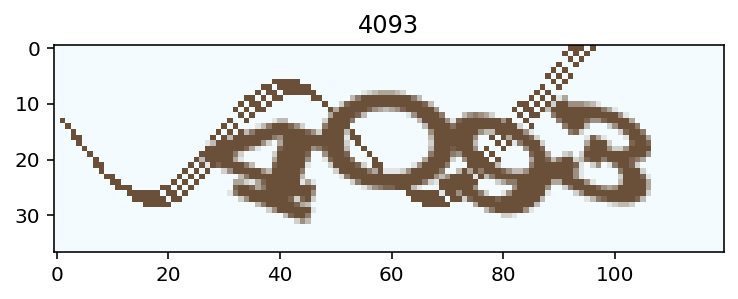

In [64]:
import string
import os
import matplotlib.image as mpimg
characters = string.digits
width, height, n_len, n_class = 120, 37, 4, len(characters)
img_path = "train"
img_list = os.listdir(img_path)

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)


def get_batch(characters, batch_size, n_len, n_class, width, height):
    X = np.zeros((batch_size, height, width, 3), dtype=np.float32)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    for i in range(batch_size):                
        img_name = random.choice(img_list)
        img_file = os.path.join(img_path, img_name)
        img = mpimg.imread(img_file)
        X[i] = np.array(img)
        for j, ch in enumerate(img_name[:4]):
            y[j][i, :] = 0
            y[j][i, characters.find(ch)] = 1      
    return X, y
      
        
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X,y = get_batch(characters, 5000, n_len, n_class, width, height)
print(X.shape)
plt.imshow(X[0])
plt.title(decode(y))

In [65]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

In [4]:
#train
def train_model(model):
    from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
    from tensorflow.keras.optimizers import Adam

    callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv'), ModelCheckpoint('cnn_best.h5', save_best_only=True)]

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(1e-3, amsgrad=True), 
                  metrics=['accuracy'])

    X_train,y_train = get_batch(characters, 5000, n_len, n_class, width, height)
    model.fit(X_train, y_train, validation_split=0.1 ,epochs=10, batch_size=128, workers=4, use_multiprocessing=True, callbacks=callbacks)   
    return model

In [5]:
model = train_model(model)

Train on 4500 samples, validate on 500 samples
Epoch 1/10
4500/4500 [==============================] - 216s 48ms/sample - loss: 9.6801 - c1_loss: 2.4160 - c2_loss: 2.3929 - c3_loss: 2.4369 - c4_loss: 2.4187 - c1_acc: 0.1229 - c2_acc: 0.1202 - c3_acc: 0.1191 - c4_acc: 0.1127 - val_loss: 12.5605 - val_c1_loss: 3.5218 - val_c2_loss: 3.2626 - val_c3_loss: 2.9201 - val_c4_loss: 2.8584 - val_c1_acc: 0.0900 - val_c2_acc: 0.1000 - val_c3_acc: 0.0960 - val_c4_acc: 0.1200
Epoch 2/10
4500/4500 [==============================] - 228s 51ms/sample - loss: 8.4157 - c1_loss: 2.0561 - c2_loss: 2.0838 - c3_loss: 2.1199 - c4_loss: 2.1318 - c1_acc: 0.2347 - c2_acc: 0.2262 - c3_acc: 0.2140 - c4_acc: 0.2064 - val_loss: 10.0556 - val_c1_loss: 2.5277 - val_c2_loss: 2.4995 - val_c3_loss: 2.5655 - val_c4_loss: 2.4618 - val_c1_acc: 0.0740 - val_c2_acc: 0.1040 - val_c3_acc: 0.0720 - val_c4_acc: 0.1000
Epoch 3/10
4500/4500 [==============================] - 203s 45ms/sample - loss: 5.7084 - c1_loss: 1.3251 - c2_lo

In [34]:
def retrain_model(model):
    from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
    from tensorflow.keras.optimizers import Adam
    model.load_weights('cnn_best.h5')
    
    callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv', append=True), 
                 ModelCheckpoint('cnn_best.h5', save_best_only=True)]

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(1e-4, amsgrad=True), 
                  metrics=['accuracy'])
    X_train,y_train = get_batch(characters, 5000, n_len, n_class, width, height)
    model.fit(X_train, y_train, validation_split=0.1 ,epochs=100, batch_size=128, workers=4, use_multiprocessing=True, callbacks=callbacks)   
    return model

In [35]:
model = retrain_model(model)

Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - ETA: 2:12 - loss: 6.4376 - c1_loss: 1.5338 - c2_loss: 1.5771 - c3_loss: 1.6527 - c4_loss: 1.6740 - c1_acc: 0.3984 - c2_acc: 0.4609 - c3_acc: 0.3516 - c4_acc: 0.382 - ETA: 1:41 - loss: 6.4088 - c1_loss: 1.5139 - c2_loss: 1.5672 - c3_loss: 1.6483 - c4_loss: 1.6794 - c1_acc: 0.4453 - c2_acc: 0.4609 - c3_acc: 0.3555 - c4_acc: 0.390 - ETA: 1:29 - loss: 6.3504 - c1_loss: 1.5098 - c2_loss: 1.5469 - c3_loss: 1.6643 - c4_loss: 1.6294 - c1_acc: 0.4375 - c2_acc: 0.4635 - c3_acc: 0.3411 - c4_acc: 0.440 - ETA: 1:23 - loss: 6.3143 - c1_loss: 1.5048 - c2_loss: 1.5277 - c3_loss: 1.6557 - c4_loss: 1.6262 - c1_acc: 0.4453 - c2_acc: 0.4707 - c3_acc: 0.3516 - c4_acc: 0.435 - ETA: 1:18 - loss: 6.3162 - c1_loss: 1.4993 - c2_loss: 1.5482 - c3_loss: 1.6505 - c4_loss: 1.6182 - c1_acc: 0.4500 - c2_acc: 0.4641 - c3_acc: 0.3734 - c4_acc: 0.428 - ETA: 1:13 - loss: 6.3037 - c1_loss: 1.4927 - c2_loss: 1.5408 - c3_

4500/4500 [==============================] - ETA: 1:24 - loss: 3.6897 - c1_loss: 0.7815 - c2_loss: 0.9154 - c3_loss: 0.9686 - c4_loss: 1.0241 - c1_acc: 0.8203 - c2_acc: 0.7578 - c3_acc: 0.7344 - c4_acc: 0.718 - ETA: 1:19 - loss: 3.6267 - c1_loss: 0.7783 - c2_loss: 0.9049 - c3_loss: 0.9207 - c4_loss: 1.0228 - c1_acc: 0.8047 - c2_acc: 0.7656 - c3_acc: 0.7656 - c4_acc: 0.722 - ETA: 1:16 - loss: 3.6599 - c1_loss: 0.7869 - c2_loss: 0.9108 - c3_loss: 0.9472 - c4_loss: 1.0150 - c1_acc: 0.7995 - c2_acc: 0.7526 - c3_acc: 0.7552 - c4_acc: 0.724 - ETA: 1:14 - loss: 3.6757 - c1_loss: 0.7829 - c2_loss: 0.9225 - c3_loss: 0.9413 - c4_loss: 1.0290 - c1_acc: 0.7969 - c2_acc: 0.7422 - c3_acc: 0.7539 - c4_acc: 0.720 - ETA: 1:12 - loss: 3.6890 - c1_loss: 0.7877 - c2_loss: 0.9082 - c3_loss: 0.9623 - c4_loss: 1.0308 - c1_acc: 0.7984 - c2_acc: 0.7469 - c3_acc: 0.7516 - c4_acc: 0.718 - ETA: 1:10 - loss: 3.6929 - c1_loss: 0.7806 - c2_loss: 0.9135 - c3_loss: 0.9698 - c4_loss: 1.0290 - c1_acc: 0.8060 - c2_acc: 0

4500/4500 [==============================] - ETA: 1:26 - loss: 1.7215 - c1_loss: 0.4029 - c2_loss: 0.4125 - c3_loss: 0.4612 - c4_loss: 0.4450 - c1_acc: 0.9297 - c2_acc: 0.9609 - c3_acc: 0.9141 - c4_acc: 0.968 - ETA: 1:23 - loss: 1.7791 - c1_loss: 0.4057 - c2_loss: 0.4058 - c3_loss: 0.4883 - c4_loss: 0.4794 - c1_acc: 0.9453 - c2_acc: 0.9570 - c3_acc: 0.9180 - c4_acc: 0.949 - ETA: 1:21 - loss: 1.8382 - c1_loss: 0.3884 - c2_loss: 0.4277 - c3_loss: 0.4944 - c4_loss: 0.5277 - c1_acc: 0.9479 - c2_acc: 0.9531 - c3_acc: 0.9219 - c4_acc: 0.924 - ETA: 1:19 - loss: 1.8145 - c1_loss: 0.3760 - c2_loss: 0.4243 - c3_loss: 0.5001 - c4_loss: 0.5142 - c1_acc: 0.9531 - c2_acc: 0.9492 - c3_acc: 0.9180 - c4_acc: 0.931 - ETA: 1:15 - loss: 1.7951 - c1_loss: 0.3739 - c2_loss: 0.4223 - c3_loss: 0.4919 - c4_loss: 0.5070 - c1_acc: 0.9484 - c2_acc: 0.9484 - c3_acc: 0.9250 - c4_acc: 0.931 - ETA: 1:13 - loss: 1.7831 - c1_loss: 0.3796 - c2_loss: 0.4245 - c3_loss: 0.4810 - c4_loss: 0.4980 - c1_acc: 0.9479 - c2_acc: 0

4500/4500 [==============================] - ETA: 1:22 - loss: 0.8244 - c1_loss: 0.1804 - c2_loss: 0.1999 - c3_loss: 0.2091 - c4_loss: 0.2351 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 0.984 - ETA: 1:32 - loss: 0.8465 - c1_loss: 0.1749 - c2_loss: 0.2011 - c3_loss: 0.2239 - c4_loss: 0.2467 - c1_acc: 1.0000 - c2_acc: 0.9961 - c3_acc: 1.0000 - c4_acc: 0.988 - ETA: 1:25 - loss: 0.8043 - c1_loss: 0.1664 - c2_loss: 0.1893 - c3_loss: 0.2217 - c4_loss: 0.2269 - c1_acc: 1.0000 - c2_acc: 0.9974 - c3_acc: 0.9948 - c4_acc: 0.992 - ETA: 1:21 - loss: 0.8072 - c1_loss: 0.1656 - c2_loss: 0.1915 - c3_loss: 0.2227 - c4_loss: 0.2274 - c1_acc: 0.9980 - c2_acc: 0.9961 - c3_acc: 0.9961 - c4_acc: 0.994 - ETA: 1:18 - loss: 0.8095 - c1_loss: 0.1641 - c2_loss: 0.1913 - c3_loss: 0.2266 - c4_loss: 0.2276 - c1_acc: 0.9984 - c2_acc: 0.9953 - c3_acc: 0.9922 - c4_acc: 0.995 - ETA: 1:16 - loss: 0.8192 - c1_loss: 0.1669 - c2_loss: 0.1936 - c3_loss: 0.2274 - c4_loss: 0.2312 - c1_acc: 0.9987 - c2_acc: 0

4500/4500 [==============================] - ETA: 1:24 - loss: 0.4559 - c1_loss: 0.0953 - c2_loss: 0.1207 - c3_loss: 0.1139 - c4_loss: 0.1260 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:21 - loss: 0.4336 - c1_loss: 0.0933 - c2_loss: 0.1091 - c3_loss: 0.1062 - c4_loss: 0.1249 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:25 - loss: 0.4190 - c1_loss: 0.0886 - c2_loss: 0.1044 - c3_loss: 0.1053 - c4_loss: 0.1207 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:22 - loss: 0.4291 - c1_loss: 0.0913 - c2_loss: 0.1058 - c3_loss: 0.1097 - c4_loss: 0.1223 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:19 - loss: 0.4269 - c1_loss: 0.0914 - c2_loss: 0.1051 - c3_loss: 0.1106 - c4_loss: 0.1197 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:16 - loss: 0.4314 - c1_loss: 0.0918 - c2_loss: 0.1057 - c3_loss: 0.1129 - c4_loss: 0.1210 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:25 - loss: 0.2675 - c1_loss: 0.0561 - c2_loss: 0.0680 - c3_loss: 0.0690 - c4_loss: 0.0745 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:24 - loss: 0.2560 - c1_loss: 0.0520 - c2_loss: 0.0663 - c3_loss: 0.0660 - c4_loss: 0.0717 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:24 - loss: 0.2650 - c1_loss: 0.0553 - c2_loss: 0.0658 - c3_loss: 0.0700 - c4_loss: 0.0739 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:21 - loss: 0.2618 - c1_loss: 0.0556 - c2_loss: 0.0643 - c3_loss: 0.0684 - c4_loss: 0.0735 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:18 - loss: 0.2694 - c1_loss: 0.0566 - c2_loss: 0.0667 - c3_loss: 0.0705 - c4_loss: 0.0756 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:15 - loss: 0.2686 - c1_loss: 0.0566 - c2_loss: 0.0659 - c3_loss: 0.0707 - c4_loss: 0.0754 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:23 - loss: 0.1733 - c1_loss: 0.0373 - c2_loss: 0.0436 - c3_loss: 0.0428 - c4_loss: 0.0495 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:20 - loss: 0.1775 - c1_loss: 0.0395 - c2_loss: 0.0440 - c3_loss: 0.0440 - c4_loss: 0.0499 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:18 - loss: 0.1818 - c1_loss: 0.0402 - c2_loss: 0.0444 - c3_loss: 0.0460 - c4_loss: 0.0512 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:16 - loss: 0.1791 - c1_loss: 0.0396 - c2_loss: 0.0431 - c3_loss: 0.0461 - c4_loss: 0.0503 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:13 - loss: 0.1808 - c1_loss: 0.0397 - c2_loss: 0.0438 - c3_loss: 0.0470 - c4_loss: 0.0503 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:12 - loss: 0.1854 - c1_loss: 0.0406 - c2_loss: 0.0448 - c3_loss: 0.0481 - c4_loss: 0.0520 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:33 - loss: 0.1304 - c1_loss: 0.0285 - c2_loss: 0.0316 - c3_loss: 0.0328 - c4_loss: 0.0375 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:28 - loss: 0.1329 - c1_loss: 0.0293 - c2_loss: 0.0323 - c3_loss: 0.0342 - c4_loss: 0.0372 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:30 - loss: 0.1299 - c1_loss: 0.0291 - c2_loss: 0.0323 - c3_loss: 0.0333 - c4_loss: 0.0353 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:25 - loss: 0.1341 - c1_loss: 0.0296 - c2_loss: 0.0328 - c3_loss: 0.0353 - c4_loss: 0.0363 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:21 - loss: 0.1351 - c1_loss: 0.0296 - c2_loss: 0.0330 - c3_loss: 0.0356 - c4_loss: 0.0369 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:18 - loss: 0.1342 - c1_loss: 0.0294 - c2_loss: 0.0327 - c3_loss: 0.0352 - c4_loss: 0.0369 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:25 - loss: 0.0978 - c1_loss: 0.0221 - c2_loss: 0.0224 - c3_loss: 0.0263 - c4_loss: 0.0270 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:24 - loss: 0.1040 - c1_loss: 0.0228 - c2_loss: 0.0249 - c3_loss: 0.0281 - c4_loss: 0.0282 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:21 - loss: 0.1047 - c1_loss: 0.0230 - c2_loss: 0.0255 - c3_loss: 0.0281 - c4_loss: 0.0282 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:18 - loss: 0.1027 - c1_loss: 0.0227 - c2_loss: 0.0249 - c3_loss: 0.0273 - c4_loss: 0.0278 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:17 - loss: 0.1017 - c1_loss: 0.0227 - c2_loss: 0.0242 - c3_loss: 0.0271 - c4_loss: 0.0276 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:14 - loss: 0.1036 - c1_loss: 0.0233 - c2_loss: 0.0247 - c3_loss: 0.0274 - c4_loss: 0.0283 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:25 - loss: 0.0798 - c1_loss: 0.0201 - c2_loss: 0.0182 - c3_loss: 0.0203 - c4_loss: 0.0212 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:24 - loss: 0.0792 - c1_loss: 0.0186 - c2_loss: 0.0181 - c3_loss: 0.0210 - c4_loss: 0.0214 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:23 - loss: 0.0810 - c1_loss: 0.0188 - c2_loss: 0.0192 - c3_loss: 0.0212 - c4_loss: 0.0218 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:20 - loss: 0.0822 - c1_loss: 0.0188 - c2_loss: 0.0199 - c3_loss: 0.0215 - c4_loss: 0.0220 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:16 - loss: 0.0842 - c1_loss: 0.0192 - c2_loss: 0.0203 - c3_loss: 0.0224 - c4_loss: 0.0223 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:14 - loss: 0.0839 - c1_loss: 0.0191 - c2_loss: 0.0201 - c3_loss: 0.0223 - c4_loss: 0.0225 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:25 - loss: 0.0715 - c1_loss: 0.0160 - c2_loss: 0.0169 - c3_loss: 0.0190 - c4_loss: 0.0196 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:23 - loss: 0.0683 - c1_loss: 0.0152 - c2_loss: 0.0161 - c3_loss: 0.0185 - c4_loss: 0.0185 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:23 - loss: 0.0685 - c1_loss: 0.0149 - c2_loss: 0.0162 - c3_loss: 0.0183 - c4_loss: 0.0191 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:19 - loss: 0.0698 - c1_loss: 0.0149 - c2_loss: 0.0167 - c3_loss: 0.0189 - c4_loss: 0.0193 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:18 - loss: 0.0696 - c1_loss: 0.0149 - c2_loss: 0.0167 - c3_loss: 0.0187 - c4_loss: 0.0192 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:15 - loss: 0.0696 - c1_loss: 0.0150 - c2_loss: 0.0167 - c3_loss: 0.0186 - c4_loss: 0.0193 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:27 - loss: 0.0613 - c1_loss: 0.0150 - c2_loss: 0.0146 - c3_loss: 0.0155 - c4_loss: 0.0162 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:27 - loss: 0.0595 - c1_loss: 0.0138 - c2_loss: 0.0146 - c3_loss: 0.0153 - c4_loss: 0.0159 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:23 - loss: 0.0630 - c1_loss: 0.0138 - c2_loss: 0.0154 - c3_loss: 0.0169 - c4_loss: 0.0169 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:21 - loss: 0.0616 - c1_loss: 0.0137 - c2_loss: 0.0149 - c3_loss: 0.0164 - c4_loss: 0.0167 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:19 - loss: 0.0623 - c1_loss: 0.0135 - c2_loss: 0.0151 - c3_loss: 0.0168 - c4_loss: 0.0169 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:19 - loss: 0.0614 - c1_loss: 0.0134 - c2_loss: 0.0149 - c3_loss: 0.0164 - c4_loss: 0.0167 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:28 - loss: 0.0473 - c1_loss: 0.0106 - c2_loss: 0.0122 - c3_loss: 0.0126 - c4_loss: 0.0119 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:24 - loss: 0.0506 - c1_loss: 0.0117 - c2_loss: 0.0125 - c3_loss: 0.0129 - c4_loss: 0.0135 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:23 - loss: 0.0516 - c1_loss: 0.0119 - c2_loss: 0.0127 - c3_loss: 0.0132 - c4_loss: 0.0138 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:20 - loss: 0.0517 - c1_loss: 0.0117 - c2_loss: 0.0127 - c3_loss: 0.0133 - c4_loss: 0.0140 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:17 - loss: 0.0521 - c1_loss: 0.0117 - c2_loss: 0.0128 - c3_loss: 0.0136 - c4_loss: 0.0140 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:14 - loss: 0.0523 - c1_loss: 0.0117 - c2_loss: 0.0127 - c3_loss: 0.0137 - c4_loss: 0.0142 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:40 - loss: 0.0493 - c1_loss: 0.0118 - c2_loss: 0.0118 - c3_loss: 0.0125 - c4_loss: 0.0133 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:34 - loss: 0.0474 - c1_loss: 0.0112 - c2_loss: 0.0115 - c3_loss: 0.0122 - c4_loss: 0.0126 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:30 - loss: 0.0459 - c1_loss: 0.0106 - c2_loss: 0.0112 - c3_loss: 0.0118 - c4_loss: 0.0123 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:27 - loss: 0.0459 - c1_loss: 0.0105 - c2_loss: 0.0112 - c3_loss: 0.0117 - c4_loss: 0.0124 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:23 - loss: 0.0457 - c1_loss: 0.0103 - c2_loss: 0.0114 - c3_loss: 0.0117 - c4_loss: 0.0123 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:20 - loss: 0.0458 - c1_loss: 0.0104 - c2_loss: 0.0113 - c3_loss: 0.0117 - c4_loss: 0.0124 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:29 - loss: 0.0367 - c1_loss: 0.0087 - c2_loss: 0.0086 - c3_loss: 0.0093 - c4_loss: 0.0100 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:24 - loss: 0.0388 - c1_loss: 0.0089 - c2_loss: 0.0088 - c3_loss: 0.0106 - c4_loss: 0.0105 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:23 - loss: 0.0403 - c1_loss: 0.0093 - c2_loss: 0.0091 - c3_loss: 0.0109 - c4_loss: 0.0110 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:19 - loss: 0.0411 - c1_loss: 0.0094 - c2_loss: 0.0094 - c3_loss: 0.0111 - c4_loss: 0.0112 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:17 - loss: 0.0402 - c1_loss: 0.0092 - c2_loss: 0.0093 - c3_loss: 0.0107 - c4_loss: 0.0110 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:14 - loss: 0.0408 - c1_loss: 0.0092 - c2_loss: 0.0096 - c3_loss: 0.0108 - c4_loss: 0.0111 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:36 - loss: 0.0367 - c1_loss: 0.0081 - c2_loss: 0.0092 - c3_loss: 0.0094 - c4_loss: 0.0101 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:31 - loss: 0.0364 - c1_loss: 0.0081 - c2_loss: 0.0090 - c3_loss: 0.0094 - c4_loss: 0.0099 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:28 - loss: 0.0360 - c1_loss: 0.0080 - c2_loss: 0.0090 - c3_loss: 0.0092 - c4_loss: 0.0097 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:26 - loss: 0.0353 - c1_loss: 0.0079 - c2_loss: 0.0089 - c3_loss: 0.0090 - c4_loss: 0.0095 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:22 - loss: 0.0355 - c1_loss: 0.0080 - c2_loss: 0.0088 - c3_loss: 0.0090 - c4_loss: 0.0096 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:20 - loss: 0.0360 - c1_loss: 0.0081 - c2_loss: 0.0089 - c3_loss: 0.0092 - c4_loss: 0.0098 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:33 - loss: 0.0334 - c1_loss: 0.0071 - c2_loss: 0.0083 - c3_loss: 0.0084 - c4_loss: 0.0096 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:29 - loss: 0.0326 - c1_loss: 0.0074 - c2_loss: 0.0078 - c3_loss: 0.0082 - c4_loss: 0.0093 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:24 - loss: 0.0335 - c1_loss: 0.0076 - c2_loss: 0.0080 - c3_loss: 0.0084 - c4_loss: 0.0095 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:21 - loss: 0.0333 - c1_loss: 0.0076 - c2_loss: 0.0081 - c3_loss: 0.0083 - c4_loss: 0.0094 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:19 - loss: 0.0329 - c1_loss: 0.0074 - c2_loss: 0.0079 - c3_loss: 0.0082 - c4_loss: 0.0093 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:19 - loss: 0.0328 - c1_loss: 0.0075 - c2_loss: 0.0079 - c3_loss: 0.0082 - c4_loss: 0.0093 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:22 - loss: 0.0301 - c1_loss: 0.0070 - c2_loss: 0.0072 - c3_loss: 0.0073 - c4_loss: 0.0087 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:22 - loss: 0.0323 - c1_loss: 0.0075 - c2_loss: 0.0077 - c3_loss: 0.0080 - c4_loss: 0.0090 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:19 - loss: 0.0314 - c1_loss: 0.0072 - c2_loss: 0.0075 - c3_loss: 0.0080 - c4_loss: 0.0087 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:17 - loss: 0.0307 - c1_loss: 0.0070 - c2_loss: 0.0074 - c3_loss: 0.0078 - c4_loss: 0.0084 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:16 - loss: 0.0309 - c1_loss: 0.0071 - c2_loss: 0.0073 - c3_loss: 0.0079 - c4_loss: 0.0086 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:15 - loss: 0.0308 - c1_loss: 0.0070 - c2_loss: 0.0073 - c3_loss: 0.0079 - c4_loss: 0.0086 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:32 - loss: 0.0293 - c1_loss: 0.0066 - c2_loss: 0.0065 - c3_loss: 0.0078 - c4_loss: 0.0083 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:28 - loss: 0.0290 - c1_loss: 0.0065 - c2_loss: 0.0068 - c3_loss: 0.0076 - c4_loss: 0.0081 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:26 - loss: 0.0289 - c1_loss: 0.0064 - c2_loss: 0.0070 - c3_loss: 0.0076 - c4_loss: 0.0080 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:23 - loss: 0.0282 - c1_loss: 0.0063 - c2_loss: 0.0068 - c3_loss: 0.0074 - c4_loss: 0.0077 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:20 - loss: 0.0280 - c1_loss: 0.0062 - c2_loss: 0.0068 - c3_loss: 0.0073 - c4_loss: 0.0077 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:18 - loss: 0.0284 - c1_loss: 0.0063 - c2_loss: 0.0069 - c3_loss: 0.0074 - c4_loss: 0.0078 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:34 - loss: 0.0261 - c1_loss: 0.0059 - c2_loss: 0.0060 - c3_loss: 0.0072 - c4_loss: 0.0070 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:27 - loss: 0.0258 - c1_loss: 0.0058 - c2_loss: 0.0061 - c3_loss: 0.0068 - c4_loss: 0.0071 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:22 - loss: 0.0260 - c1_loss: 0.0060 - c2_loss: 0.0062 - c3_loss: 0.0069 - c4_loss: 0.0070 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:20 - loss: 0.0255 - c1_loss: 0.0058 - c2_loss: 0.0061 - c3_loss: 0.0067 - c4_loss: 0.0069 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:17 - loss: 0.0257 - c1_loss: 0.0059 - c2_loss: 0.0061 - c3_loss: 0.0067 - c4_loss: 0.0070 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:15 - loss: 0.0262 - c1_loss: 0.0059 - c2_loss: 0.0062 - c3_loss: 0.0069 - c4_loss: 0.0071 - c1_acc: 1.0000 - c2_acc: 1

4500/4500 [==============================] - ETA: 1:28 - loss: 0.0233 - c1_loss: 0.0053 - c2_loss: 0.0057 - c3_loss: 0.0056 - c4_loss: 0.0067 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:28 - loss: 0.0236 - c1_loss: 0.0054 - c2_loss: 0.0059 - c3_loss: 0.0058 - c4_loss: 0.0065 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:24 - loss: 0.0239 - c1_loss: 0.0054 - c2_loss: 0.0059 - c3_loss: 0.0060 - c4_loss: 0.0066 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:22 - loss: 0.0237 - c1_loss: 0.0054 - c2_loss: 0.0058 - c3_loss: 0.0059 - c4_loss: 0.0065 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:19 - loss: 0.0233 - c1_loss: 0.0054 - c2_loss: 0.0057 - c3_loss: 0.0059 - c4_loss: 0.0064 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.000 - ETA: 1:18 - loss: 0.0233 - c1_loss: 0.0054 - c2_loss: 0.0056 - c3_loss: 0.0059 - c4_loss: 0.0063 - c1_acc: 1.0000 - c2_acc: 1

(-0.5, 119.5, 36.5, -0.5)

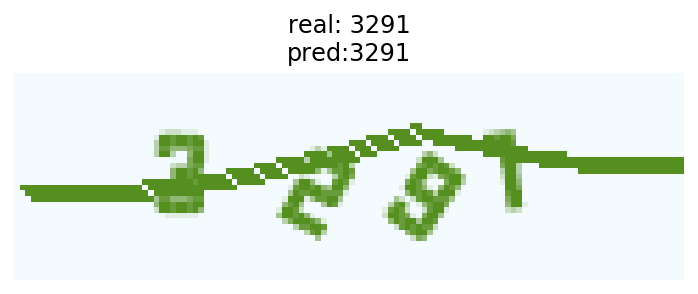

In [82]:
model.load_weights('cnn_best.h5')


#test model
X,y = get_batch(characters, 1, n_len, n_class, width, height)
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

In [73]:
#evaluate
def evaluate(model, batch_num=100):
    batch_acc = 0
    X,y = get_batch(characters, batch_num, n_len, n_class, width, height)

    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=-1).T
    y_true = np.argmax(y, axis=-1).T

    batch_acc += (y_true == y_pred).all(axis=-1).mean()
    return batch_acc / batch_num

evaluate(model)

0.0052

In [83]:
import os
img_names = []
for file_name in os.listdir():
    if file_name[-3:] in ['jpg', 'png']:
        img_names.append(file_name)

img_paths = [os.getcwd()+"\\"+img_name for img_name in img_names]
print(img_paths)

['C:\\Users\\dell\\Desktop\\VScodePlayGround\\captcha_break\\x0.jpg', 'C:\\Users\\dell\\Desktop\\VScodePlayGround\\captcha_break\\x1.jpg', 'C:\\Users\\dell\\Desktop\\VScodePlayGround\\captcha_break\\x2.jpg', 'C:\\Users\\dell\\Desktop\\VScodePlayGround\\captcha_break\\x3.jpg', 'C:\\Users\\dell\\Desktop\\VScodePlayGround\\captcha_break\\x4.jpg', 'C:\\Users\\dell\\Desktop\\VScodePlayGround\\captcha_break\\x5.jpg', 'C:\\Users\\dell\\Desktop\\VScodePlayGround\\captcha_break\\x6.jpg', 'C:\\Users\\dell\\Desktop\\VScodePlayGround\\captcha_break\\x7.jpg', 'C:\\Users\\dell\\Desktop\\VScodePlayGround\\captcha_break\\x8.jpg', 'C:\\Users\\dell\\Desktop\\VScodePlayGround\\captcha_break\\x9.jpg']


D:\dev_tools\Anaconda3_2019.07\lib\site-packages\tensorflow\python\keras\api\_v1\keras\layers\__init__.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from tensorflow.python.keras.engine import InputLayer


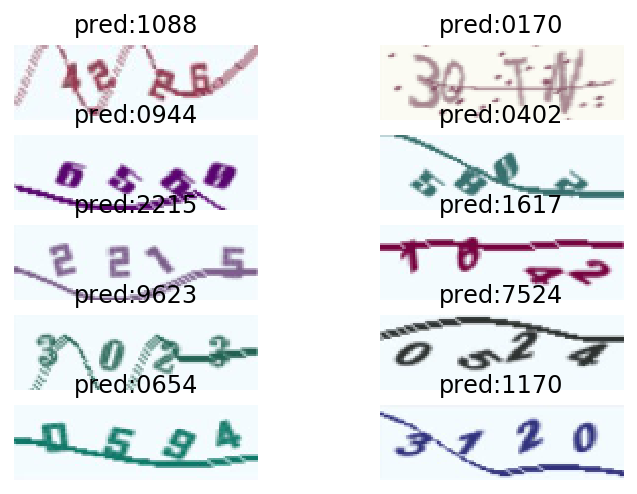

In [85]:
from PIL import Image

for i,img_path in enumerate(img_paths):    
    img = Image.open(img_path)
    img = img.resize((width, height))
    x = np.array(img) / 255.0
    x = x[np.newaxis,:]
    y_pred = model.predict(x)
    x.shape
    plt.subplot(5,2,i+1).title.set_text('pred:%s'%(decode(y_pred)))
    plt.subplot(5,2,i+1).imshow(x[0], cmap='gray')
    plt.axis('off')